In [1]:
!pip install haversine

In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
from requests import get
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt  

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library
import itertools
import seaborn as sns

#Calculate distance (Haversine)
import haversine as hs

# Web scraping

In [3]:
#to look like a human
headers = ({'User-Agent':
            'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/41.0.2228.0 Safari/537.36'})

In [4]:
#url ='https://m.aruodas.lt/sklypai-pardavimui/vilniaus-rajone/?FOfferType=1&change_region=1&FAreaOverAllMin=6&FAreaOverAllMax=20&FPriceMax=40000'

In [5]:
#response=get(url, headers=headers)
#response

In [6]:
all_pages = 20
all_address=[]
all_area=[]
all_price=[]
n_pages=0
for page in range(1,all_pages):
    n_pages += 1
    url='https://m.aruodas.lt/sklypai-pardavimui/vilniuje/puslapis/{}/?FOfferType=1&change_region=1&FAreaOverAllMin=6&FAreaOverAllMax=30&from_search=1&FIntendance=property&FPriceMax=500000&FBuildingType=1'.format(n_pages)
    r = get(url, headers=headers)
    page_html = BeautifulSoup(r.text, 'html.parser')
    address = page_html.find_all('span', class_="item-address-v3")
    area = page_html.find_all('span', class_="item-description-v3")
    price = page_html.find_all('span', class_="item-price-main-v3")
    for address_1 in address:
        address_1=address_1.text
        address_1=address_1.strip()
        all_address.append(address_1)
    for area_1 in area:
        area_1=area_1.text
        area_1=area_1.strip()
        area_1=float(''.join(itertools.takewhile(str.isdigit, area_1)))
        all_area.append(area_1)
    for price_1 in price:
        price_1=price_1.find_all('span')[0].text
        price_1=price_1.replace(' ','')
        price_1=int(''.join(itertools.takewhile(str.isdigit, price_1)))
        all_price.append(price_1)

In [7]:
land=pd.DataFrame(columns=['Price', 'Address', 'Area'] )

In [8]:
land['Price']=all_price
land['Address']=all_address
land['Area']=all_area

In [9]:

land[['District', 'Street']]=land.Address.str.split(',',expand=True)
land['Latitude'] = ''
land['Longitude'] = ''
land['Distance_center']=''
land['Price_a']=''
land.head()

,Price,Address,Area,District,Street,Latitude,Longitude,Distance_center,Price_a
0,41000,"Pilaitė, Geryčių g.",10.0,Pilaitė,Geryčių g.,,,,
1,26900,"Vilnius, Žaizdrių g.",8.0,Vilnius,Žaizdrių g.,,,,
2,31500,"Vilnius, Jovariškių g.",8.0,Vilnius,Jovariškių g.,,,,
3,27000,"Pavilnys, Zigmo Starkaus g.",6.0,Pavilnys,Zigmo Starkaus g.,,,,
4,47500,"Dvarčionys, Juodvarnių Sodų 28-oji g.",12.0,Dvarčionys,Juodvarnių Sodų 28-oji g.,,,,


In [10]:
vilnius_center= (54.688469572896764, 25.270548930896332)
#vilnius_center_longitude= 25.270548930896332
for index, row in land.iterrows():
    geolocator = Nominatim(user_agent="Vilnius")
    location = geolocator.geocode( '{}, Vilnius'.format(row['Street']))
    land.loc[index,'Latitude'] = location.latitude
    land.loc[index,'Longitude'] = location.longitude
    land.loc[index,'Distance_center']=hs.haversine((location.latitude,location.longitude),vilnius_center)
    land.loc[index, 'Price_a']=land.loc[index, 'Price']/land.loc[index, 'Area']

In [11]:
land1=land[land.District != 'Vilnius']
land1['Distance_center']=land1['Distance_center'].astype(float)
land1['Price_a']=land1['Price_a'].astype(float)
land1

<ipython-input-11-23bac928ce58>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land1['Distance_center']=land1['Distance_center'].astype(float)
<ipython-input-11-23bac928ce58>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  land1['Price_a']=land1['Price_a'].astype(float)


,Price,Address,Area,District,Street,Latitude,Longitude,Distance_center,Price_a
0,41000,"Pilaitė, Geryčių g.",10.0,Pilaitė,Geryčių g.,54.7079,25.1511,7.973741,4100.000000
3,27000,"Pavilnys, Zigmo Starkaus g.",6.0,Pavilnys,Zigmo Starkaus g.,54.6587,25.3731,7.381333,4500.000000
4,47500,"Dvarčionys, Juodvarnių Sodų 28-oji g.",12.0,Dvarčionys,Juodvarnių Sodų 28-oji g.,54.7204,25.3895,8.426879,3958.333333
5,134000,"Antakalnis, Meiriškių g.",20.0,Antakalnis,Meiriškių g.,54.7983,25.4387,16.299724,6700.000000
6,69500,"Kalnėnai, Albanų g.",6.0,Kalnėnai,Albanų g.,54.6532,25.3562,6.758027,11583.333333
...,...,...,...,...,...,...,...,...,...
488,33000,"Grigaičių k., Jaunimo g.",11.0,Grigaičių k.,Jaunimo g.,54.1835,25.0421,58.065214,3000.000000
489,30000,"Didieji Gulbinai, Dvariškių g.",8.0,Didieji Gulbinai,Dvariškių g.,54.7926,25.2873,11.631282,3750.000000
490,152000,"Gariūnai, Titnago g.",19.0,Gariūnai,Titnago g.,54.6449,25.1958,6.828694,8000.000000
491,200000,"Gariūnai, Titnago g.",25.0,Gariūnai,Titnago g.,54.6449,25.1958,6.828694,8000.000000


In [12]:
land1.head()

,Price,Address,Area,District,Street,Latitude,Longitude,Distance_center,Price_a
0,41000,"Pilaitė, Geryčių g.",10.0,Pilaitė,Geryčių g.,54.7079,25.1511,7.973741,4100.000000
3,27000,"Pavilnys, Zigmo Starkaus g.",6.0,Pavilnys,Zigmo Starkaus g.,54.6587,25.3731,7.381333,4500.000000
4,47500,"Dvarčionys, Juodvarnių Sodų 28-oji g.",12.0,Dvarčionys,Juodvarnių Sodų 28-oji g.,54.7204,25.3895,8.426879,3958.333333
5,134000,"Antakalnis, Meiriškių g.",20.0,Antakalnis,Meiriškių g.,54.7983,25.4387,16.299724,6700.000000
6,69500,"Kalnėnai, Albanų g.",6.0,Kalnėnai,Albanų g.,54.6532,25.3562,6.758027,11583.333333


In [13]:
land1=land1[land1['District'].astype(str).str.split().str[1] !='k.']
land1

,Price,Address,Area,District,Street,Latitude,Longitude,Distance_center,Price_a
0,41000,"Pilaitė, Geryčių g.",10.0,Pilaitė,Geryčių g.,54.7079,25.1511,7.973741,4100.000000
3,27000,"Pavilnys, Zigmo Starkaus g.",6.0,Pavilnys,Zigmo Starkaus g.,54.6587,25.3731,7.381333,4500.000000
4,47500,"Dvarčionys, Juodvarnių Sodų 28-oji g.",12.0,Dvarčionys,Juodvarnių Sodų 28-oji g.,54.7204,25.3895,8.426879,3958.333333
5,134000,"Antakalnis, Meiriškių g.",20.0,Antakalnis,Meiriškių g.,54.7983,25.4387,16.299724,6700.000000
6,69500,"Kalnėnai, Albanų g.",6.0,Kalnėnai,Albanų g.,54.6532,25.3562,6.758027,11583.333333
...,...,...,...,...,...,...,...,...,...
487,39000,"Antavilis, Antavilių g.",7.0,Antavilis,Antavilių g.,54.7941,25.3977,14.299381,5571.428571
489,30000,"Didieji Gulbinai, Dvariškių g.",8.0,Didieji Gulbinai,Dvariškių g.,54.7926,25.2873,11.631282,3750.000000
490,152000,"Gariūnai, Titnago g.",19.0,Gariūnai,Titnago g.,54.6449,25.1958,6.828694,8000.000000
491,200000,"Gariūnai, Titnago g.",25.0,Gariūnai,Titnago g.,54.6449,25.1958,6.828694,8000.000000


In [15]:
#land1.groupby('Rajonas').agg({'Price': ['mean'],'Distance_center': ['mean']})
#agg({'Price': ['mean']})
#land1
#land1
#,'Distance_center': ['mean']
Districts=land1.groupby('District').agg({'Price': ['mean', 'count'], 'Area':['mean'], 'Distance_center':['mean'], 'Price_a':['mean']})
Districts=Districts.reset_index()
Districts.columns = ['District', 'Price_mean', 'Count', 'Area_mean', 'D_c_mean', 'Price_a_mean']
Districts

,District,Price_mean,Count,Area_mean,D_c_mean,Price_a_mean
0,Antakalnis,123906.132075,53,10.849057,8.907121,11105.151090
1,Antavilis,32333.333333,3,7.000000,14.299381,4619.047619
2,Aukštieji Paneriai,30020.000000,5,11.600000,12.494783,2634.166667
3,Bajorai,81693.333333,18,9.833333,7.964268,8456.380471
4,Balsiai,54621.636364,33,10.454545,12.897427,5227.398705
5,Baltupiai,291896.000000,5,18.400000,4.265829,16005.692308
6,Didieji Gulbinai,35892.307692,13,9.538462,11.666389,3813.720724
7,Dvarčionys,66625.000000,4,12.000000,8.134248,6089.781746
8,Fabijoniškės,140250.000000,4,7.750000,4.820623,18200.892857
9,Filaretai,310000.000000,1,27.000000,3.333830,11481.481481


# Vizualization

[Text(0.5, 1.0, 'Price dependence from area size')]

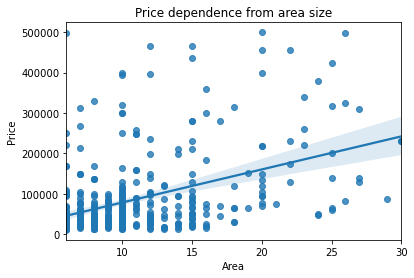

In [38]:
sns.regplot(x="Area", y="Price", data=land1).set(title='Price dependence from area size')

[Text(0.5, 1.0, 'Price dependence from distance to city center')]

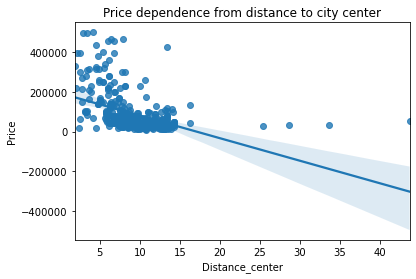

In [34]:
sns.regplot(x="Distance_center", y="Price", data=land1).set(title='Price dependence from distance to city center')

[Text(0.5, 1.0, 'Price/area dependence from distance to city center')]

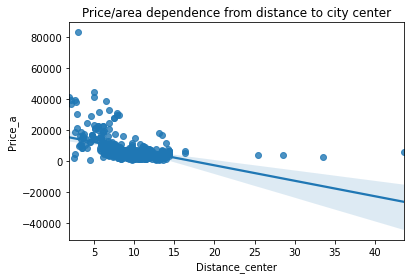

In [35]:
sns.regplot(x="Distance_center", y="Price_a", data=land1).set(title='Price/area dependence from distance to city center')

[Text(0.5, 1.0, 'Price/area dependence from distance to city center filtered <40000')]

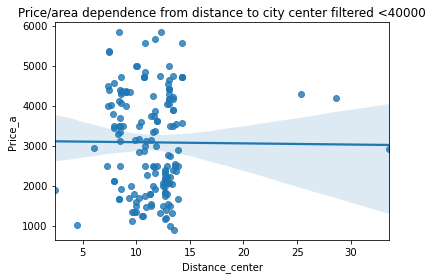

In [36]:
land2=land1[land1['Price']<40000]
sns.regplot(x="Distance_center", y="Price_a", data=land2).set(title='Price/area dependence from distance to city center filtered <40000')

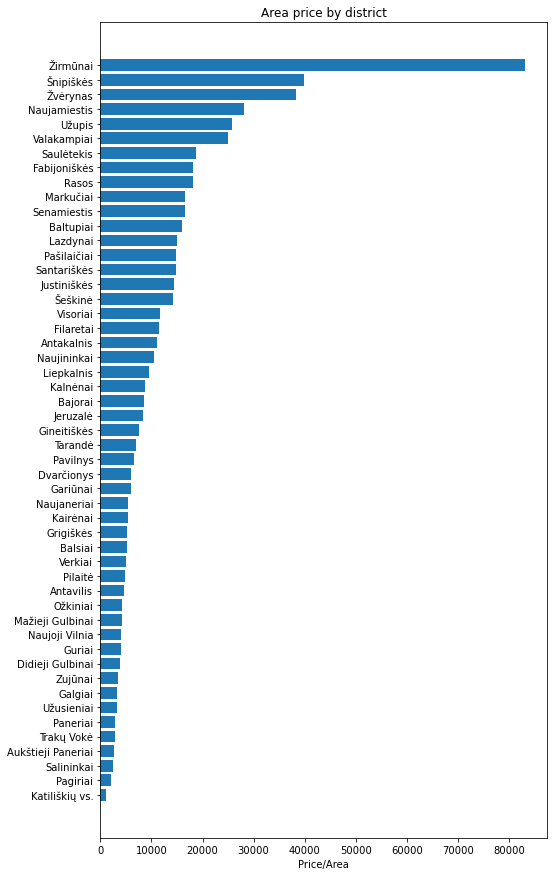

In [21]:
Districts_p=Districts.sort_values(by=['Price_a_mean'], ascending=True)
plt.figure(figsize=(8, 15))
plt.barh(Districts_p['District'], Districts_p['Price_a_mean'])
plt.xlabel('Price/Area')
plt.title('Area price by district')
plt.show()
#rajonai['count']

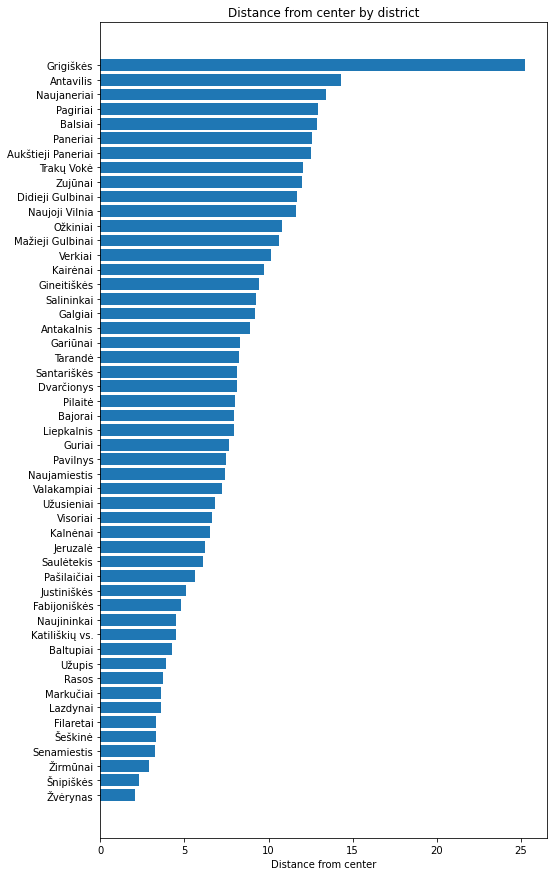

In [22]:
Districts_d=Districts.sort_values(by=['D_c_mean'], ascending=True)
plt.figure(figsize=(8, 15))
plt.barh(Districts_d['District'], Districts_d['D_c_mean'])
plt.xlabel('Distance from center')
plt.title('Distance from center by district')
plt.show()

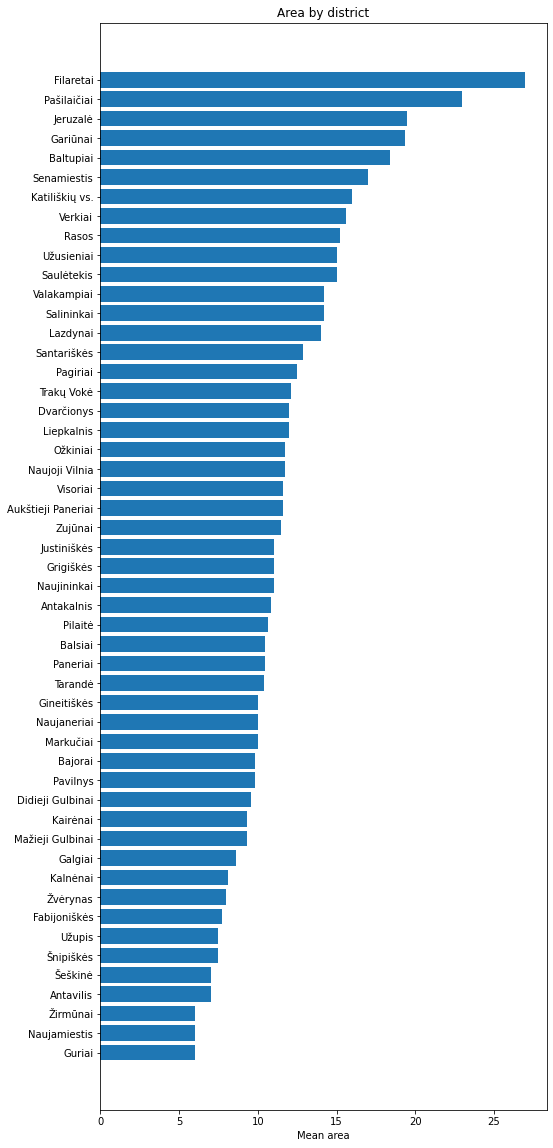

In [23]:
Districts_a=Districts.sort_values(by=['Area_mean'], ascending=True)
plt.figure(figsize=(8, 20))
plt.barh(Districts_a['District'], Districts_a['Area_mean'])
plt.xlabel('Mean area')
plt.title('Area by district')
plt.show()

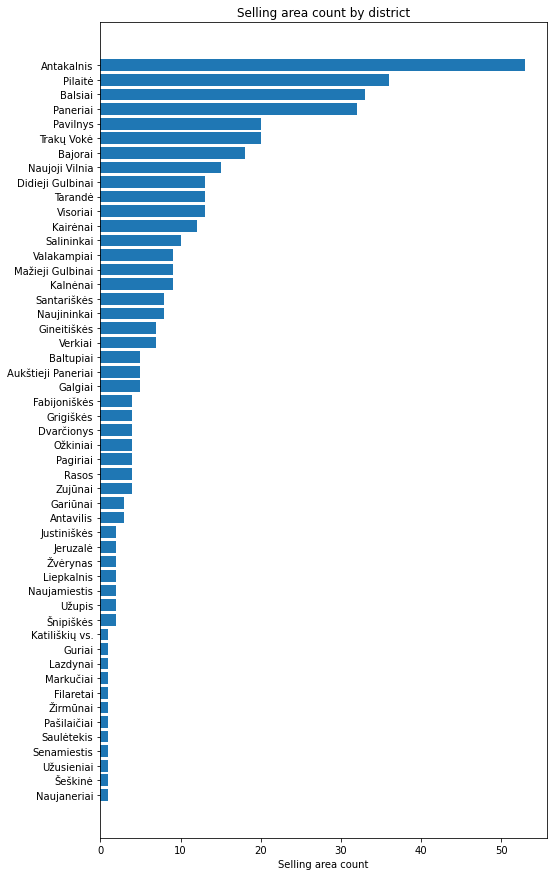

In [29]:
Districts_c=Districts.sort_values(by=['Count'], ascending=True)
plt.figure(figsize=(8, 15))
plt.barh(Districts_c['District'], Districts_c['Count'])
plt.xlabel('Selling area count')
plt.title('Selling area count by district')
plt.show()

In [26]:
address = 'Vilnius'

geolocator = Nominatim(user_agent="Vilnius")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Vilnius are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Vilnius are 54.6870458, 25.2829111.


In [28]:
# create map
Areas = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map

for lat, lon, poi in zip(land1['Latitude'], land1['Longitude'], land1['District']):
        folium.CircleMarker(
        [lat, lon],
        radius=5,
        fill=True,
        fill_opacity=0.7).add_to(Areas)
       
Areas